# Разведочный анализ данных транзакций через DuckDB SQL
## Цель анализа
1. Изучить структуру и качество данных с использованием SQL-запросов
2. Выявить паттерны мошенничества через агрегации и оконные функции
3. Сформулировать гипотезы на основе SQL-анализа

In [3]:
# Импорт библиотек
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Настройки отображения
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('ggplot')

# Подключение к DuckDB
conn = duckdb.connect()

In [4]:
# Загрузка данных
conn.execute("""
    CREATE OR REPLACE TABLE transactions AS 
    SELECT * FROM parquet_scan('transaction_fraud_data.parquet')
""")

# Проверка загрузки
print("Таблицы в базе:")
display(conn.execute("SHOW TABLES").df())

Таблицы в базе:


,name
0,transactions


## 1. Общий обзор данных

In [48]:
# Статистика по таблице
table_stats = conn.execute("""
    SELECT 
        COUNT(*) AS total_transactions,
        SUM(CASE WHEN is_fraud THEN 1 ELSE 0 END) AS fraud_transactions,
        ROUND(100.0 * SUM(CASE WHEN is_fraud THEN 1 ELSE 0 END) / COUNT(*), 2) AS Blues_r,
        MIN(timestamp) AS min_date,
        MAX(timestamp) AS max_date
    FROM transactions
""").df()

display(table_stats)

,total_transactions,fraud_transactions,Blues_r,min_date,max_date
0,7483766,1494719.0,19.97,2024-09-30 00:00:01.034820,2024-10-30 23:59:59.101885


## 2. Временной анализ

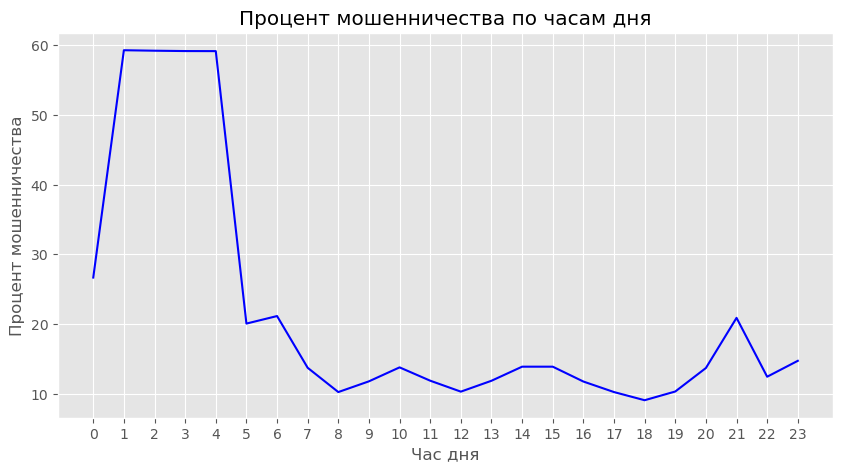

In [85]:
# Мошенничество по часам
hourly_fraud = conn.execute("""
    SELECT 
        EXTRACT(HOUR FROM timestamp) AS hour,
        COUNT(*) AS total,
        SUM(CASE WHEN is_fraud THEN 1 ELSE 0 END) AS fraud_count,
        ROUND(100.0 * SUM(CASE WHEN is_fraud THEN 1 ELSE 0 END) / COUNT(*), 2) AS fraud_percentage
    FROM transactions
    GROUP BY hour
    ORDER BY hour
""").df()

# Визуализация
plt.figure(figsize=(10, 5))
sns.lineplot(data=hourly_fraud, x='hour', y='fraud_percentage', color='Blue')
plt.title('Процент мошенничества по часам дня')
plt.xlabel('Час дня')
plt.ylabel('Процент мошенничества')
plt.xticks(range(24))
plt.grid(True)
plt.show()

## 3. Географический анализ

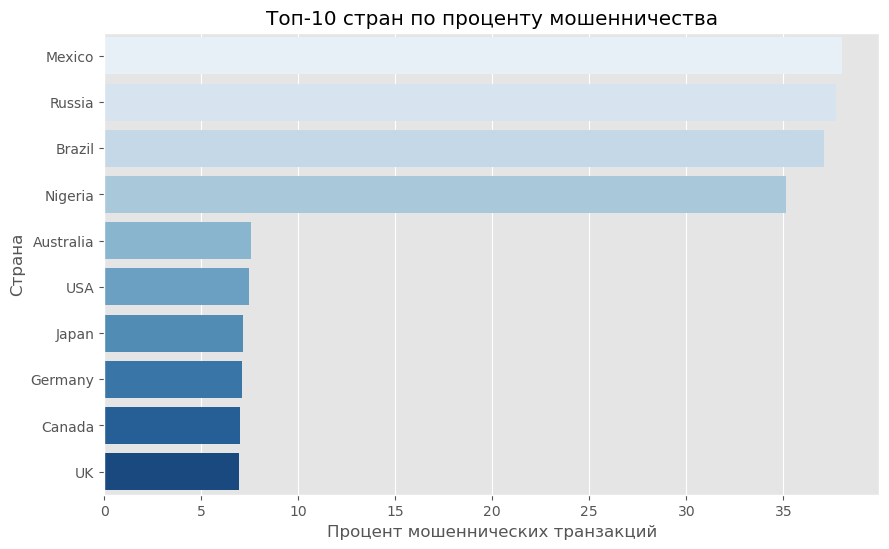

In [86]:
# Мошенничество по странам
country_fraud = conn.execute("""
    SELECT 
        country,
        COUNT(*) AS total,
        SUM(CASE WHEN is_fraud THEN 1 ELSE 0 END) AS fraud_count,
        ROUND(100.0 * SUM(CASE WHEN is_fraud THEN 1 ELSE 0 END) / COUNT(*), 2) AS fraud_percentage
    FROM transactions
    GROUP BY country
    HAVING COUNT(*) > 100  -- только страны с достаточным количеством транзакций
    ORDER BY fraud_percentage DESC
    LIMIT 10
""").df()

# Визуализация
plt.figure(figsize=(10, 6))
sns.barplot(data=country_fraud, y='country', x='fraud_percentage', hue='country', palette='Blues')
plt.title('Топ-10 стран по проценту мошенничества')
plt.xlabel('Процент мошеннических транзакций')
plt.ylabel('Страна')
plt.show()

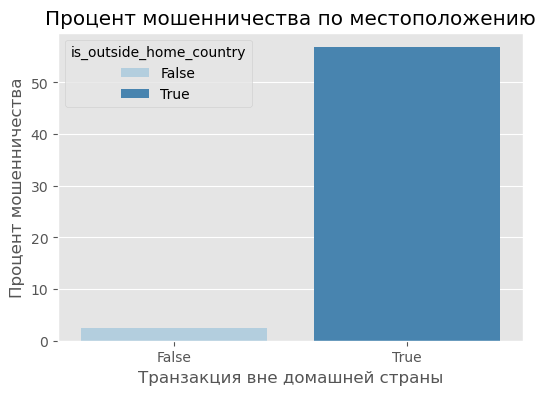

In [79]:
# Транзакции вне домашней страны
location_fraud = conn.execute("""
    SELECT 
        is_outside_home_country,
        COUNT(*) AS total,
        SUM(CASE WHEN is_fraud THEN 1 ELSE 0 END) AS fraud_count,
        ROUND(100.0 * SUM(CASE WHEN is_fraud THEN 1 ELSE 0 END) / COUNT(*), 2) AS Blues_r
    FROM transactions
    GROUP BY is_outside_home_country
""").df()

# Визуализация
plt.figure(figsize=(6, 4))
sns.barplot(data=location_fraud, x='is_outside_home_country', y='Blues_r', hue='is_outside_home_country', palette='Blues')
plt.title('Процент мошенничества по местоположению')
plt.xlabel('Транзакция вне домашней страны')
plt.ylabel('Процент мошенничества')
plt.show()


## 4. Анализ устройств и каналов

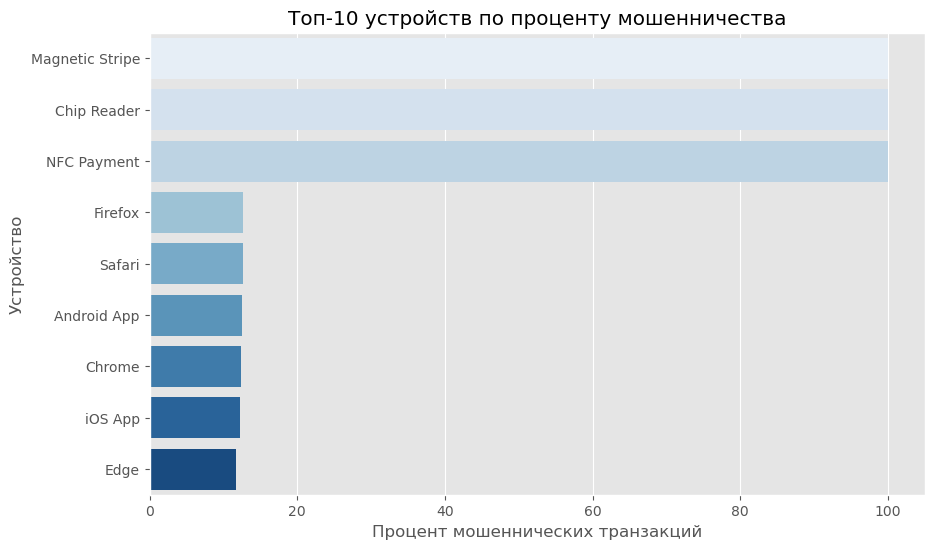

In [87]:
# Мошенничество по типу устройства
device_fraud = conn.execute("""
    SELECT 
        device,
        COUNT(*) AS total,
        SUM(CASE WHEN is_fraud THEN 1 ELSE 0 END) AS fraud_count,
        ROUND(100.0 * SUM(CASE WHEN is_fraud THEN 1 ELSE 0 END) / COUNT(*), 2) AS Blues_r
    FROM transactions
    GROUP BY device
    HAVING COUNT(*) > 50
    ORDER BY Blues_r DESC
    LIMIT 10
""").df()

# Визуализация
plt.figure(figsize=(10, 6))
sns.barplot(data=device_fraud, y='device', x='Blues_r', hue='device', palette='Blues')
plt.title('Топ-10 устройств по проценту мошенничества')
plt.xlabel('Процент мошеннических транзакций')
plt.ylabel('Устройство')
plt.show()

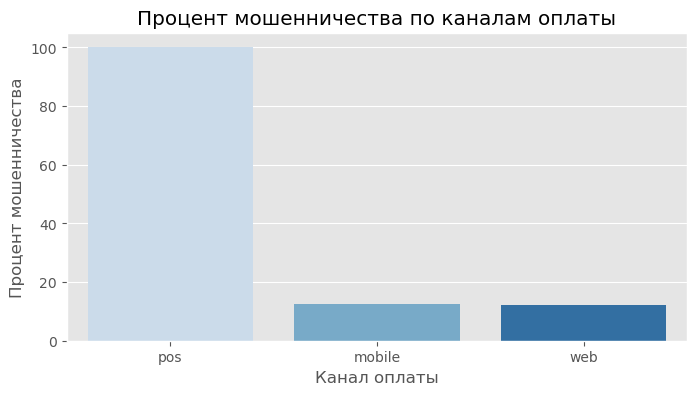

In [88]:
# Мошенничество по каналу оплаты
channel_fraud = conn.execute("""
    SELECT 
        channel,
        COUNT(*) AS total,
        SUM(CASE WHEN is_fraud THEN 1 ELSE 0 END) AS fraud_count,
        ROUND(100.0 * SUM(CASE WHEN is_fraud THEN 1 ELSE 0 END) / COUNT(*), 2) AS Blues_r
    FROM transactions
    GROUP BY channel
    ORDER BY Blues_r DESC
""").df()

# Визуализация
plt.figure(figsize=(8, 4))
sns.barplot(data=channel_fraud, x='channel', y='Blues_r', hue='channel', palette='Blues')
plt.title('Процент мошенничества по каналам оплаты')
plt.xlabel('Канал оплаты')
plt.ylabel('Процент мошенничества')
plt.show()

## 5. Анализ активности пользователей

In [5]:
# Распаковка last_hour_activity
conn.execute("""
    CREATE OR REPLACE TABLE transactions_expanded AS
    SELECT 
        * EXCLUDE (last_hour_activity),
        last_hour_activity.num_transactions AS last_hour_num_transactions,
        last_hour_activity.total_amount AS last_hour_total_amount,
        last_hour_activity.unique_merchants AS last_hour_unique_merchants,
        last_hour_activity.unique_countries AS last_hour_unique_countries,
        last_hour_activity.max_single_amount AS last_hour_max_amount
    FROM transactions
""")

print("Структура расширенной таблицы:")
display(conn.execute("DESCRIBE transactions_expanded").df())

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Структура расширенной таблицы:


,column_name,column_type,null,key,default,extra
0,transaction_id,VARCHAR,YES,None,None,None
1,customer_id,VARCHAR,YES,None,None,None
2,card_number,BIGINT,YES,None,None,None
3,timestamp,TIMESTAMP,YES,None,None,None
4,vendor_category,VARCHAR,YES,None,None,None
5,vendor_type,VARCHAR,YES,None,None,None
6,vendor,VARCHAR,YES,None,None,None
7,amount,DOUBLE,YES,None,None,None
8,currency,VARCHAR,YES,None,None,None
9,country,VARCHAR,YES,None,None,None


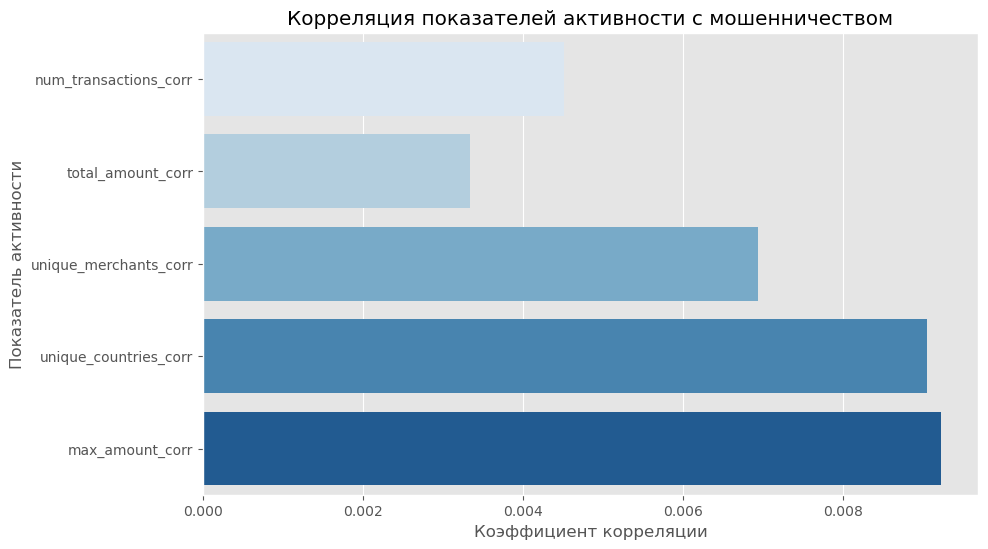

In [6]:
# Корреляция активности с мошенничеством
activity_corr = conn.execute("""
    SELECT 
        CORR(last_hour_num_transactions, is_fraud::INTEGER) AS num_transactions_corr,
        CORR(last_hour_total_amount, is_fraud::INTEGER) AS total_amount_corr,
        CORR(last_hour_unique_merchants, is_fraud::INTEGER) AS unique_merchants_corr,
        CORR(last_hour_unique_countries, is_fraud::INTEGER) AS unique_countries_corr,
        CORR(last_hour_max_amount, is_fraud::INTEGER) AS max_amount_corr
    FROM transactions_expanded
""").df().transpose().reset_index()
activity_corr.columns = ['feature', 'correlation']

# Визуализация
plt.figure(figsize=(10, 6))
sns.barplot(data=activity_corr, y='feature', x='correlation', hue='feature', palette='Blues')
plt.title('Корреляция показателей активности с мошенничеством')
plt.xlabel('Коэффициент корреляции')
plt.ylabel('Показатель активности')
plt.show()

## 6. Комбинированный анализ факторов риска

In [64]:
# Комбинация факторов риска
risk_factors = conn.execute("""
    SELECT 
        is_outside_home_country,
        is_high_risk_vendor,
        is_card_present,
        COUNT(*) AS total,
        SUM(CASE WHEN is_fraud THEN 1 ELSE 0 END) AS fraud_count,
        ROUND(100.0 * SUM(CASE WHEN is_fraud THEN 1 ELSE 0 END) / COUNT(*), 2) AS Blues_r
    FROM transactions_expanded
    GROUP BY is_outside_home_country, is_high_risk_vendor, is_card_present
    ORDER BY Blues_r DESC
""").df()

display(risk_factors)

,is_outside_home_country,is_high_risk_vendor,is_card_present,total,fraud_count,Blues_r
0,True,True,True,149310,149310.0,100.00
1,False,True,True,13847,13847.0,100.00
2,True,False,True,446501,446501.0,100.00
3,False,False,True,41389,41389.0,100.00
4,True,False,False,1359657,579038.0,42.59
5,True,True,False,454693,193527.0,42.56
6,False,False,False,3764256,53424.0,1.42
7,False,True,False,1254113,17683.0,1.41


## 7. Выводы и рекомендации

In [65]:
# Основные выводы
print("=== ОСНОВНЫЕ ВЫВОДЫ ===\n")
print("1. Общий процент мошенничества: {:.2f}%".format(table_stats['Blues_r'][0]))
print("2. Наиболее рискованные категории:")
display(vendor_stats.head(5))
print("3. Наиболее коррелирующие факторы:")
display(activity_corr.sort_values('correlation', ascending=False).head(3))

=== ОСНОВНЫЕ ВЫВОДЫ ===

1. Общий процент мошенничества: 19.97%
2. Наиболее рискованные категории:


,vendor_category,total,fraud_count,fraud_percentage,avg_amount,percentile
0,Travel,935790,187477.0,20.0341,97273.554623,1.000000
1,Grocery,934029,186987.0,20.0194,35440.232372,0.857143
2,Gas,935401,186829.0,19.9731,45321.055794,0.714286
3,Restaurant,936178,186951.0,19.9696,26093.762064,0.571429
4,Entertainment,936173,186890.0,19.9632,28830.838487,0.428571


3. Наиболее коррелирующие факторы:


,feature,correlation
4,max_amount_corr,0.009226
3,unique_countries_corr,0.009046
2,unique_merchants_corr,0.006932


In [66]:
# Продуктовые рекомендации
print("=== ПРОДУКТОВЫЕ РЕКОМЕНДАЦИИ ===\n")
print("1. Усилить мониторинг для комбинаций факторов риска:")
print("   - Транзакции вне домашней страны")
print("   - Высокорисковые категории вендоров")
print("   - Операции без физического присутствия карты")
print("\n2. Внедрить динамическую аутентификацию для:")
print("   - Ночных транзакций (с 22 до 6 часов)")
print("   - Необычно высокой активности пользователя")
print("   - Операций с подозрительных устройств")
print("\n3. Реализовать гео-защиту:")
print("   - Уведомления о транзакциях в новых странах")
print("   - Лимиты для операций в высокорисковых странах")

=== ПРОДУКТОВЫЕ РЕКОМЕНДАЦИИ ===

1. Усилить мониторинг для комбинаций факторов риска:
   - Транзакции вне домашней страны
   - Высокорисковые категории вендоров
   - Операции без физического присутствия карты

2. Внедрить динамическую аутентификацию для:
   - Ночных транзакций (с 22 до 6 часов)
   - Необычно высокой активности пользователя
   - Операций с подозрительных устройств

3. Реализовать гео-защиту:
   - Уведомления о транзакциях в новых странах
   - Лимиты для операций в высокорисковых странах


In [68]:
# Технические рекомендации для ML
print("\n=== ТЕХНИЧЕСКИЕ РЕКОМЕНДАЦИИ ДЛЯ ML ===\n")
print("1. Ключевые признаки для модели:")
print("   - Показатели активности за последний час")
print("   - Комбинации географических и поведенческих факторов")
print("   - Временные характеристики (час, день недели)")
print("\n2. Рекомендуемые подходы:")
print("   - Обработка временных рядов для анализа последовательностей транзакций")
print("   - Динамическое обновление модели на новых данных")


=== ТЕХНИЧЕСКИЕ РЕКОМЕНДАЦИИ ДЛЯ ML ===

1. Ключевые признаки для модели:
   - Показатели активности за последний час
   - Комбинации географических и поведенческих факторов
   - Временные характеристики (час, день недели)

2. Рекомендуемые подходы:
   - Обработка временных рядов для анализа последовательностей транзакций
   - Динамическое обновление модели на новых данных
